In [2]:
%matplotlib inline
import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import vonmises
import torch
from data import EMSequenceDataset
from model import Encoder
from torch.utils.data import DataLoader

In [3]:
dataset = EMSequenceDataset(f_samp_hz=240, roi_size=32, pixels_per_degree=120)
model = Encoder(f_samp_hz=32, spatial_kernel_size=32)

model.initialize()

dataloader = DataLoader(dataset)


Loading 69 images from upenn ...


Loading images: 100%|█████████████████████████████████████████████| 69/69 [00:00<00:00, 6102.41it/s]


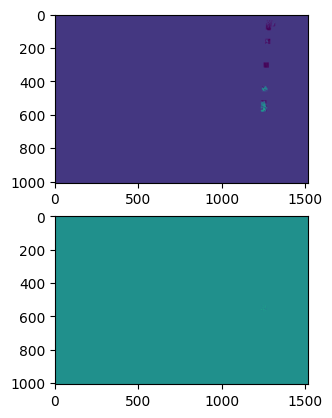

In [5]:

retinal_input, target_image, pos = next(iter(dataloader))

output, _ = model.forward(retinal_input)

recon = utils.frames_to_image(target_image.shape, output, pos)

# plt.figure()
fig, axs =  plt.subplots(2)
axs[0].imshow(target_image[0,:])
axs[1].imshow(recon[0,:].detach().numpy())
plt.show()

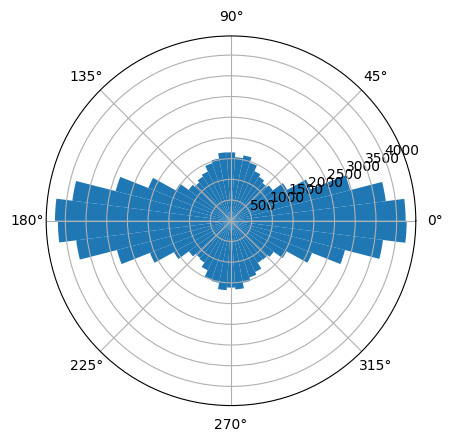

In [4]:
fs = 240.
ppd = 240.
D = 20.
a = int((0.15 + np.random.random() * 0.15) * fs)

drift_pre = np.astype(utils.brownian_eye_trace(D, fs, 32) / 60 * ppd, np.int64)
saccade = np.astype(utils.generate_saccade(10., np.pi/2., fs) * ppd, np.int64)
drift_post = np.astype(utils.brownian_eye_trace(D, fs, a) / 60 * ppd, np.int64)

trace = np.concat((drift_pre.T, saccade.T + drift_pre[:,-1]))
trace = np.concat((trace, drift_post.T + trace[-1, :]))

theta = np.zeros(100000)
for i in range(theta.size):
    match np.random.randint(4):
        case 0:
            center = 0
            kappa = 10
        case 1:
            center = np.pi
            kappa = 10
        case 2:
            center = np.pi / 2.
            kappa = 2
        case 3:
            center = -np.pi / 2.
            kappa = 2

    theta[i] = vonmises.rvs(loc=center, kappa=kappa)

plt.figure()
# plt.plot(trace)
ax = plt.subplot(projection='polar')
ax.hist(theta, bins=50)
plt.show()




[0. 0.]


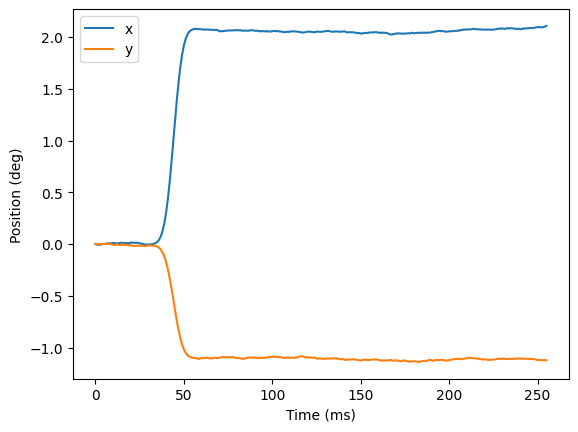

In [5]:
em, amp, dir = utils.gen_em_sequence(32, 1000, 20)
print(em[0,:])

plt.figure()
plt.plot(em)
plt.xlabel("Time (ms)")
plt.ylabel("Position (deg)")
plt.legend(["x", "y"])
plt.show()

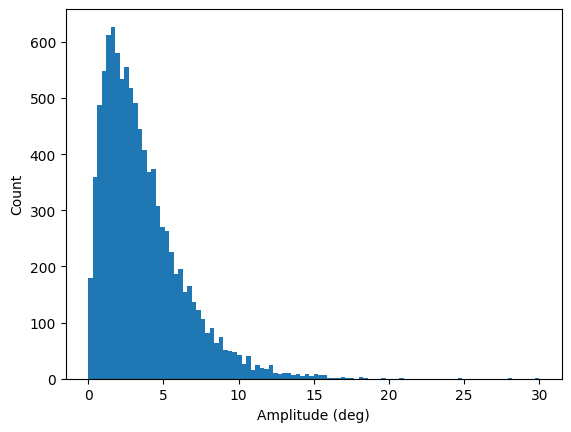

In [6]:

a = np.random.gamma(1.8, 2, 10000)
plt.figure()
plt.hist(a.T, bins=100)
plt.ylabel("Count")
plt.xlabel("Amplitude (deg)")
plt.show()

In [5]:
dataset = EMSequenceDataset()
video = dataset[0]


Loading 69 images from upenn ...


Loading images: 100%|█████████████████████████████████████████████| 69/69 [00:00<00:00, 3919.11it/s]


TypeError: expected Tensor as element 1 in argument 0, but got builtin_function_or_method

torch.Size([101, 32, 32])
tensor(3.8122)


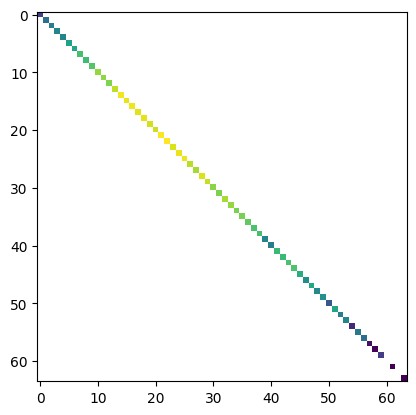

In [47]:

print(video.shape)
segment1 = video[0:32,:,:]
segment2 = video[0:32,:]

x = torch.stack((segment1.ravel(), segment2.ravel()))

hist2, edges = torch.histogramdd(x.T, [64, 64])

pxy = hist2 / hist2.sum()
px = pxy.sum(dim=1)
py = pxy.sum(dim=0)
px_py = px[:,None] * py[None,:]
non_zero = pxy > 0

mi = torch.sum(pxy[non_zero] * torch.log(pxy[non_zero] / px_py[non_zero]))

print(mi)

plt.figure()
plt.imshow(hist2.log10())